# EM HCP-Brick (Poisson) — End-to-End

Notebook generado automáticamente.

## 1) Generación de datos mock

In [1]:
import numpy as np
import pandas as pd
import math

def simulate_hcp_brick_poisson(
    n_hcps=400,
    n_bricks=80,
    avg_bricks_per_hcp=2.5,
    seed=42,
):
    rng = np.random.default_rng(seed)

    specialties = np.array(["GP", "CARDIO", "ENDO", "ONCO", "PULMO"])
    spec = rng.choice(specialties, size=n_hcps, p=[0.45, 0.18, 0.15, 0.12, 0.10])

    seniority = rng.integers(0, 21, size=n_hcps)  # 0..20
    potential = rng.lognormal(mean=0.0, sigma=0.6, size=n_hcps)

    spec_df = pd.get_dummies(spec, prefix="spec")

    X = np.column_stack([
        np.ones(n_hcps),                # intercept
        seniority / 10.0,               # scaled
        np.log1p(potential),            # log feature
        spec_df.to_numpy(),             # dummies (note: collinearity with intercept -> use ridge)
    ])
    feature_names = (["intercept", "seniority_x0.1", "log1p_potential"]
                     + list(spec_df.columns))

    p = X.shape[1]

    beta_true = np.zeros(p)
    beta_true[0] = -0.3
    beta_true[1] =  0.20
    beta_true[2] =  0.55
    for j, nm in enumerate(feature_names):
        if nm == "spec_CARDIO":
            beta_true[j] = 0.25
        elif nm == "spec_ONCO":
            beta_true[j] = 0.35
        elif nm == "spec_PULMO":
            beta_true[j] = 0.10
        elif nm == "spec_ENDO":
            beta_true[j] = 0.15

    lambda_true = np.exp(X @ beta_true)

    # Membership
    K = rng.poisson(lam=avg_bricks_per_hcp, size=n_hcps)
    K = np.clip(K, 1, max(1, n_bricks // 2))

    brick_pop = rng.lognormal(mean=0.0, sigma=0.7, size=n_bricks)
    brick_pop = brick_pop / brick_pop.sum()

    rows = []
    for h in range(n_hcps):
        bricks_h = rng.choice(n_bricks, size=K[h], replace=False, p=brick_pop)
        base = rng.poisson(lam=2.5)
        for b in bricks_h:
            visits = base + rng.poisson(lam=0.15 * seniority[h] + 1.0)
            w = float(visits) if visits > 0 else 0.5
            rows.append((h, b, visits, w))

    hb = pd.DataFrame(rows, columns=["hcp_id", "brick_id", "visits", "w"])

    mu = lambda_true[hb["hcp_id"].to_numpy()] * hb["w"].to_numpy()
    hb["z_true"] = rng.poisson(lam=mu)

    y_by_brick = hb.groupby("brick_id")["z_true"].sum().rename("y").reset_index()

    hcp = pd.DataFrame({
        "hcp_id": np.arange(n_hcps),
        "specialty": spec,
        "seniority": seniority,
        "potential": potential,
        "lambda_true": lambda_true,
    })
    for j, nm in enumerate(feature_names):
        hcp[nm] = X[:, j]

    meta = {"feature_names": feature_names, "beta_true": beta_true}
    return hcp, hb, y_by_brick, meta

hcp_df, hb_df, y_df, meta = simulate_hcp_brick_poisson(seed=42)
hcp_df.head(), hb_df.head(), y_df.head(), meta["feature_names"], meta["beta_true"][:6]


(   hcp_id specialty  seniority  potential  lambda_true  intercept  \
 0       0      ENDO          0   2.114398     1.607724        1.0   
 1       1        GP          6   0.859409     1.174852        1.0   
 2       2      ONCO         10   1.243677     2.002635        1.0   
 3       3      ENDO         19   0.235521     1.413857        1.0   
 4       4        GP         15   0.499669     1.249676        1.0   
 
    seniority_x0.1  log1p_potential  spec_CARDIO  spec_ENDO  spec_GP  \
 0             0.0         1.136036          0.0        1.0      0.0   
 1             0.6         0.620259          0.0        0.0      1.0   
 2             1.0         0.808116          0.0        0.0      0.0   
 3             1.9         0.211493          0.0        1.0      0.0   
 4             1.5         0.405245          0.0        0.0      1.0   
 
    spec_ONCO  spec_PULMO  
 0        0.0         0.0  
 1        0.0         0.0  
 2        1.0         0.0  
 3        0.0         0.0  
 4  

## 2) EM desde cero (vectorizado + IRLS en M-step)

In [2]:
import numpy as np
import math

def prepare_arrays(hcp_df, hb_df, y_df, feature_names):
    brick_ids = np.sort(y_df["brick_id"].unique())
    brick_map = {bid: i for i, bid in enumerate(brick_ids)}
    B = len(brick_ids)

    h = hb_df["hcp_id"].to_numpy().astype(int)
    b = hb_df["brick_id"].map(brick_map).to_numpy().astype(int)
    w = hb_df["w"].to_numpy().astype(float)

    y = np.zeros(B, dtype=float)
    idx = y_df["brick_id"].map(brick_map).to_numpy().astype(int)
    y[idx] = y_df["y"].to_numpy().astype(float)

    X = hcp_df[feature_names].to_numpy().astype(float)
    return X, h, b, w, y, brick_ids

def poisson_loglik_brick(y, mu):
    lgamma = np.vectorize(math.lgamma)
    return float(np.sum(y * np.log(mu + 1e-12) - mu - lgamma(y + 1.0)))

def irls_poisson_ridge(X, y, offset=None, alpha=1e-3, max_iter=50, tol=1e-8):
    n, p = X.shape
    if offset is None:
        offset = np.zeros(n, dtype=float)
    beta = np.zeros(p, dtype=float)

    for _ in range(max_iter):
        eta = X @ beta + offset
        mu = np.exp(eta)

        W = mu
        z = eta + (y - mu) / (mu + 1e-12)

        sqrtW = np.sqrt(W)
        Xw = X * sqrtW[:, None]
        yw = (z - offset) * sqrtW

        A = Xw.T @ Xw + alpha * np.eye(p)
        rhs = Xw.T @ yw

        beta_new = np.linalg.solve(A, rhs)
        if np.linalg.norm(beta_new - beta) / (np.linalg.norm(beta) + 1e-12) < tol:
            beta = beta_new
            break
        beta = beta_new

    return beta

def em_poisson_hcp_brick(
    X, h, b, w, y,
    alpha=1e-2,
    max_em_iter=200,
    tol=1e-6,
    mstep_max_iter=50,
    verbose=True,
):
    n_hcps, p = X.shape
    B = int(np.max(b)) + 1

    w_tilde = np.bincount(h, weights=w, minlength=n_hcps).astype(float)
    offset = np.log(w_tilde + 1e-12)

    beta = np.zeros(p, dtype=float)
    history = {"loglik": [], "rel_beta_change": []}

    for t in range(max_em_iter):
        # E-step
        lambda_h = np.exp(X @ beta)
        num = lambda_h[h] * w
        den = np.bincount(b, weights=num, minlength=B).astype(float)

        zhat = y[b] * (num / (den[b] + 1e-12))

        # M-step
        y_tilde = np.bincount(h, weights=zhat, minlength=n_hcps).astype(float)
        beta_new = irls_poisson_ridge(X, y_tilde, offset=offset, alpha=alpha, max_iter=mstep_max_iter)

        ll = poisson_loglik_brick(y, den)
        rel = float(np.linalg.norm(beta_new - beta) / (np.linalg.norm(beta) + 1e-12))
        history["loglik"].append(ll)
        history["rel_beta_change"].append(rel)

        if verbose and (t % 10 == 0 or t < 5):
            print(f"EM iter {t:3d} | loglik={ll: .3f} | rel_beta_change={rel: .3e}")

        if rel < tol:
            beta = beta_new
            break
        beta = beta_new

    # final E-step
    lambda_h = np.exp(X @ beta)
    num = lambda_h[h] * w
    den = np.bincount(b, weights=num, minlength=B).astype(float)
    zhat = y[b] * (num / (den[b] + 1e-12))
    return beta, history, zhat

X, h, b, w, y, brick_ids = prepare_arrays(hcp_df, hb_df, y_df, meta["feature_names"])
beta_hat, hist, zhat = em_poisson_hcp_brick(X, h, b, w, y, alpha=1e-2, verbose=True)
beta_hat[:8], meta["beta_true"][:8], len(hist["loglik"]), hist["loglik"][-1]


EM iter   0 | loglik=-1104.928 | rel_beta_change= 3.768e+11
EM iter   1 | loglik=-307.794 | rel_beta_change= 2.174e-01
EM iter   2 | loglik=-303.615 | rel_beta_change= 2.264e-01
EM iter   3 | loglik=-300.024 | rel_beta_change= 2.255e-01
EM iter   4 | loglik=-296.938 | rel_beta_change= 2.131e-01
EM iter  10 | loglik=-285.662 | rel_beta_change= 9.272e-02
EM iter  20 | loglik=-279.809 | rel_beta_change= 2.792e-02
EM iter  30 | loglik=-278.592 | rel_beta_change= 1.074e-02
EM iter  40 | loglik=-278.339 | rel_beta_change= 4.538e-03
EM iter  50 | loglik=-278.284 | rel_beta_change= 2.016e-03
EM iter  60 | loglik=-278.271 | rel_beta_change= 9.240e-04
EM iter  70 | loglik=-278.268 | rel_beta_change= 4.327e-04
EM iter  80 | loglik=-278.267 | rel_beta_change= 2.058e-04
EM iter  90 | loglik=-278.267 | rel_beta_change= 9.899e-05
EM iter 100 | loglik=-278.267 | rel_beta_change= 4.804e-05
EM iter 110 | loglik=-278.267 | rel_beta_change= 2.348e-05
EM iter 120 | loglik=-278.267 | rel_beta_change= 1.154e

(array([-0.39064779,  0.28504024,  0.827787  , -0.06903207, -0.06652502,
        -0.1849798 ,  0.1561376 , -0.2262485 ]),
 array([-0.3 ,  0.2 ,  0.55,  0.25,  0.15,  0.  ,  0.35,  0.1 ]),
 156,
 -278.26717681773033)

## 3) Evaluación contra ground truth

,feature,beta_true,beta_hat,diff
0,intercept,-0.30,-0.390648,-0.090648
1,seniority_x0.1,0.20,0.285040,0.085040
2,log1p_potential,0.55,0.827787,0.277787
3,spec_CARDIO,0.25,-0.069032,-0.319032
4,spec_ENDO,0.15,-0.066525,-0.216525
5,spec_GP,0.00,-0.184980,-0.184980
6,spec_ONCO,0.35,0.156138,-0.193862
7,spec_PULMO,0.10,-0.226249,-0.326249


corr(eta_true, eta_hat) = 0.9604690623720786
rmse(eta_true, eta_hat) = 0.11845694489198226
corr(z_true, zhat) = 0.8652227925363385
rmse(z_true, zhat) = 2.8768931311233836
max |sum_h zhat - y| = 1.2860823517257813e-12


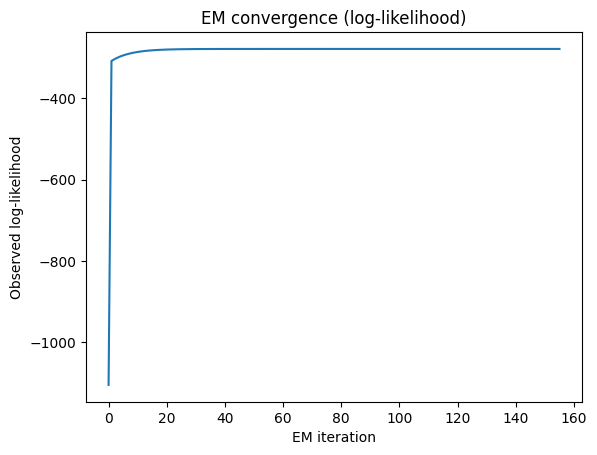

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

beta_true = meta["beta_true"]

param_df = pd.DataFrame({
    "feature": meta["feature_names"],
    "beta_true": beta_true,
    "beta_hat": beta_hat,
    "diff": beta_hat - beta_true,
})
display(param_df.head(12))

eta_true = X @ beta_true
eta_hat = X @ beta_hat
corr_eta = np.corrcoef(eta_true, eta_hat)[0, 1]
rmse_eta = float(np.sqrt(np.mean((eta_true - eta_hat) ** 2)))
print("corr(eta_true, eta_hat) =", corr_eta)
print("rmse(eta_true, eta_hat) =", rmse_eta)

hb_eval = hb_df.copy()
hb_eval["zhat"] = zhat
corr_z = np.corrcoef(hb_eval["z_true"], hb_eval["zhat"])[0, 1]
rmse_z = float(np.sqrt(np.mean((hb_eval["z_true"] - hb_eval["zhat"]) ** 2)))
print("corr(z_true, zhat) =", corr_z)
print("rmse(z_true, zhat) =", rmse_z)

brick_sum = hb_eval.groupby("brick_id")[["z_true", "zhat"]].sum().reset_index()
brick_sum = brick_sum.merge(y_df, on="brick_id", how="left")
brick_sum["zhat_minus_y"] = brick_sum["zhat"] - brick_sum["y"]
print("max |sum_h zhat - y| =", float(brick_sum["zhat_minus_y"].abs().max()))

plt.figure()
plt.plot(hist["loglik"])
plt.xlabel("EM iteration")
plt.ylabel("Observed log-likelihood")
plt.title("EM convergence (log-likelihood)")
plt.show()


## Debugging típico de EM (checklist)

1) **Suma por brick**: `sum_h zhat_{h,b}` debe ser exactamente `y_b` (errores ~1e-9).  
2) **Denominadores**: `den[b]` no debe ser 0; si lo es, bricks sin HCPs o `w=0`.  
3) **Colinealidad**: intercept + todas las dummies => usa ridge (`alpha>0`) o elimina una dummy.  
4) **Offsets**: `w_tilde` debe ser >0 para todos los HCPs incluidos (si no, filtra).  
5) **Overflow**: `exp(X beta)` puede desbordar => estandariza/clip `eta` o sube regularización.  
6) **Monotonicidad**: loglik observada no debería bajar; si baja, suele ser bug en el M-step.  
7) **Convergencia falsa**: si beta no cambia pero loglik es mala, revisa inicialización/alpha.


Aquí tienes el **Capítulo 7** con una implementación **EM desde cero en Python (sin sklearn)**, E-step **vectorizado**, M-step con **IRLS** (Poisson GLM con *offset*) + **ridge**, y un bloque de **debugging** típico.

[Download the notebook](sandbox:/mnt/data/em_hcp_brick_end_to_end.ipynb)

---

## Qué incluye el notebook (end-to-end)

* **Generación de datos mock** (`hcp_df`, `hb_df`, `y_df`) con `beta_true`, `lambda_true`, `z_true`
* **EM completo**:

  * **E-step** vectorizado con `np.bincount`
  * **M-step**: Poisson GLM con link log y **offset** `log(w_tilde)` implementado con **IRLS** + **ridge**
* **Convergencia**: trazado de log-likelihood observada por iteración + criterio de parada por cambio relativo en `beta`
* **Evaluación** contra ground truth:

  * correlación y RMSE en `η = Xβ` (más estable que comparar β directo si hay colinealidad)
  * correlación y RMSE en `z_true` vs `zhat`
  * check duro: por brick, `sum_h zhat_{h,b} == y_b`

---

## Puntos clave de implementación (por si quieres leerlo rápido)

### E-step vectorizado (la parte crítica)

En cada relación (fila) HCP–brick:

* `num[r] = lambda_h[h[r]] * w[r]`
* `den[b] = sum_{r: b[r]=b} num[r]`
* `zhat[r] = y[b[r]] * num[r] / den[b[r]]`

Esto garantiza automáticamente:
[
\sum_{h\in b} \hat z_{h,b} = y_b
]

### M-step como GLM con offset

Construyes:

* `y_tilde[h] = sum_b zhat[h,b]`
* `w_tilde[h] = sum_b w[h,b]`
* Ajustas:
  [
  \tilde y_h \sim \text{Poisson}(\exp(X_h\beta + \log \tilde w_h))
  ]
  con IRLS y ridge.

---

## Debugging típico (lo más útil en producción)

* **Check #1**: `max |sum_h zhat - y|` por brick debe ser ~`1e-9`
* **Check #2**: no debe haber bricks con `den[b]=0` (normalmente bricks sin HCPs o `w=0`)
* **Check #3**: si tienes intercept + todas las dummies, usa **ridge** (el notebook lo hace)
* **Check #4**: si `exp(Xβ)` explota, sube ridge o estandariza/clipea `η`

---

✅ **Checkpoint**: si lo abres y lo ejecutas, deberías ver:

* log-likelihood creciendo y estabilizando
* suma por brick consistente
* correlaciones razonables `z_true` vs `zhat` y `η_true` vs `η_hat`

